# 26c: Naked Lows Hurt

**Claim**: Folk wisdom says "Uncovered low offs (lone 1-0) are liabilities"

**Null Hypothesis**: Off structure doesn't affect σ(V)

**Method**:
1. Compute `n_naked_lows` = count of suits where you hold exactly 1 domino AND it's rank ≤ 2
2. Regress σ(V) against n_naked_lows (controlling for other features)
3. Test if coefficient is positive and significant

**Confirmed If**: Positive coefficient on n_naked_lows; more naked lows → higher variance

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm

from forge.analysis.utils import viz
from forge.oracle import schema
from forge.oracle.rng import deal_from_seed

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Define Naked Lows Feature

In [2]:
def domino_suits(d_id: int) -> set:
    """Return set of suits this domino belongs to."""
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:
        return {pips[0]}  # Doubles belong to one suit
    return {pips[0], pips[1]}

def domino_rank_in_suit(d_id: int, suit: int) -> int:
    """Return rank of domino within a suit (higher pip in that suit context).
    
    For non-doubles, rank is the 'off' pip (the one NOT in the suit).
    For doubles, rank is the pip value.
    """
    pips = schema.domino_pips(d_id)
    if pips[0] == pips[1]:  # Double
        return pips[0]
    # For non-double, the "rank" within a suit is the other pip
    if pips[0] == suit:
        return pips[1]  # Return the off-pip
    else:
        return pips[0]  # Return the off-pip

def compute_naked_lows(hand: list, trump_suit: int = None) -> int:
    """Count naked lows in a hand.
    
    A 'naked low' is a singleton in a suit with rank ≤ 2 (where rank is the off-pip).
    Excludes trump suit if specified.
    
    Returns count of naked lows.
    """
    # Group dominoes by suit
    suit_holdings = {s: [] for s in range(7)}
    for d in hand:
        for suit in domino_suits(d):
            suit_holdings[suit].append(d)
    
    # Count naked lows
    n_naked_lows = 0
    for suit in range(7):
        if trump_suit is not None and suit == trump_suit:
            continue  # Skip trump suit
        
        holdings = suit_holdings[suit]
        if len(holdings) == 1:  # Singleton
            d = holdings[0]
            rank = domino_rank_in_suit(d, suit)
            if rank <= 2:  # Low rank (0, 1, or 2)
                n_naked_lows += 1
    
    return n_naked_lows

# Test
test_hand = [0, 1, 2, 3, 4, 5, 6]  # 0-0, 1-0, 1-1, 2-0, 2-1, 2-2, 3-0
print(f"Test hand: {[f'{schema.domino_pips(d)}' for d in test_hand]}")
print(f"Naked lows (no trump): {compute_naked_lows(test_hand)}")
print(f"Naked lows (trump=0): {compute_naked_lows(test_hand, trump_suit=0)}")

Test hand: ['(0, 0)', '(1, 0)', '(1, 1)', '(2, 0)', '(2, 1)', '(2, 2)', '(3, 0)']
Naked lows (no trump): 1
Naked lows (trump=0): 1


## 2. Load Existing Feature Data

In [3]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)

print(f"Loaded {len(df)} hands")
print(f"σ(V) range: [{df['V_std'].min():.1f}, {df['V_std'].max():.1f}]")

Loaded 200 hands
σ(V) range: [0.0, 37.7]


In [4]:
# Compute naked lows for each hand
naked_lows_data = []

for _, row in df.iterrows():
    seed = int(row['base_seed'])
    trump = int(row['trump_suit'])
    
    hands = deal_from_seed(seed)
    p0_hand = hands[0]
    
    # Compute features
    n_naked_lows = compute_naked_lows(p0_hand, trump_suit=trump)
    n_naked_lows_any = compute_naked_lows(p0_hand, trump_suit=None)  # Including trump
    
    naked_lows_data.append({
        'base_seed': seed,
        'n_naked_lows': n_naked_lows,
        'n_naked_lows_any': n_naked_lows_any,
    })

naked_lows_df = pd.DataFrame(naked_lows_data)

# Merge with main features
df = df.merge(naked_lows_df, on='base_seed')

print(f"Naked lows distribution:")
print(df['n_naked_lows'].value_counts().sort_index())
print(f"\nMean: {df['n_naked_lows'].mean():.2f}")

Naked lows distribution:
n_naked_lows
0    76
1    81
2    39
3     3
4     1
Name: count, dtype: int64

Mean: 0.86


## 3. Statistical Analysis

In [5]:
# Bivariate correlation: n_naked_lows vs σ(V)
r, p_value = stats.pearsonr(df['n_naked_lows'], df['V_std'])

print("BIVARIATE CORRELATION: n_naked_lows vs σ(V)")
print("="*50)
print(f"Pearson r: {r:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05 and r > 0:
    print("\n✓ SIGNIFICANT POSITIVE: More naked lows → higher variance")
elif p_value < 0.05 and r < 0:
    print("\n? SIGNIFICANT NEGATIVE: More naked lows → lower variance (unexpected)")
else:
    print("\n✗ NOT SIGNIFICANT: No relationship detected")

BIVARIATE CORRELATION: n_naked_lows vs σ(V)
Pearson r: -0.1198
p-value: 0.0911

✗ NOT SIGNIFICANT: No relationship detected


In [6]:
# Multivariate regression: control for other features
# Does n_naked_lows predict σ(V) after controlling for n_doubles, trump_count, etc?

X = df[['n_naked_lows', 'n_doubles', 'trump_count', 'n_voids', 'n_singletons']]
X = sm.add_constant(X)
y = df['V_std']

model = sm.OLS(y, X).fit()

print("\nMULTIVARIATE REGRESSION: σ(V) ~ n_naked_lows + controls")
print("="*60)
print(model.summary().tables[1])


MULTIVARIATE REGRESSION: σ(V) ~ n_naked_lows + controls
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.3682      2.697      6.809      0.000      13.048      23.688
n_naked_lows    -1.9899      0.951     -2.092      0.038      -3.866      -0.114
n_doubles       -1.4083      0.785     -1.794      0.074      -2.957       0.140
trump_count     -0.7067      0.511     -1.382      0.169      -1.715       0.302
n_voids         -0.4756      1.561     -0.305      0.761      -3.555       2.604
n_singletons     0.9366      0.969      0.966      0.335      -0.975       2.848


In [7]:
# Extract key coefficient
naked_lows_coef = model.params['n_naked_lows']
naked_lows_pval = model.pvalues['n_naked_lows']
naked_lows_ci = model.conf_int().loc['n_naked_lows']

print("\nKEY RESULT: n_naked_lows coefficient")
print("="*50)
print(f"Coefficient: {naked_lows_coef:.3f}")
print(f"95% CI: [{naked_lows_ci[0]:.3f}, {naked_lows_ci[1]:.3f}]")
print(f"p-value: {naked_lows_pval:.4f}")

if naked_lows_pval < 0.05:
    if naked_lows_coef > 0:
        print("\n✓ CONFIRMED: Each naked low increases σ(V) by {:.2f} points".format(naked_lows_coef))
    else:
        print("\n? UNEXPECTED: Naked lows decrease σ(V) by {:.2f} points".format(abs(naked_lows_coef)))
else:
    print("\n✗ NOT CONFIRMED: No significant effect")


KEY RESULT: n_naked_lows coefficient
Coefficient: -1.990
95% CI: [-3.866, -0.114]
p-value: 0.0378

? UNEXPECTED: Naked lows decrease σ(V) by 1.99 points


In [8]:
# Also test against E[V] - do naked lows hurt expected value?
r_ev, p_ev = stats.pearsonr(df['n_naked_lows'], df['V_mean'])

print("\nBONUS: n_naked_lows vs E[V]")
print("="*50)
print(f"Pearson r: {r_ev:.4f}")
print(f"p-value: {p_ev:.4f}")

if p_ev < 0.05 and r_ev < 0:
    print("\n✓ Naked lows also hurt expected value!")
elif p_ev < 0.05 and r_ev > 0:
    print("\n? Unexpected: Naked lows improve expected value")
else:
    print("\n✗ No effect on E[V]")


BONUS: n_naked_lows vs E[V]
Pearson r: 0.0745
p-value: 0.2947

✗ No effect on E[V]


## 4. Visualization

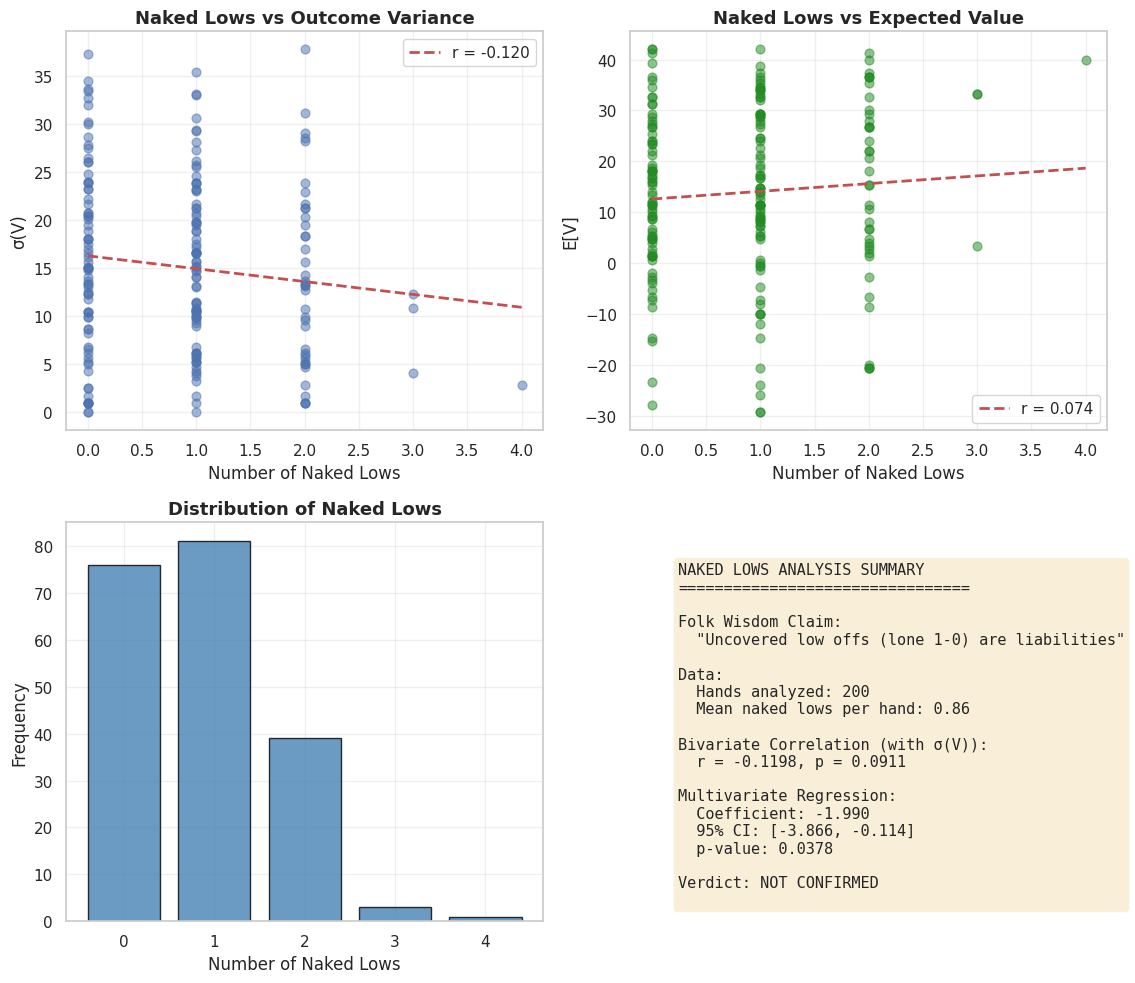

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: n_naked_lows vs σ(V)
ax = axes[0, 0]
ax.scatter(df['n_naked_lows'], df['V_std'], alpha=0.5, s=40)

# Add trend line
z = np.polyfit(df['n_naked_lows'], df['V_std'], 1)
p = np.poly1d(z)
x_line = np.array([df['n_naked_lows'].min(), df['n_naked_lows'].max()])
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'r = {r:.3f}')

ax.set_xlabel('Number of Naked Lows', fontsize=12)
ax.set_ylabel('σ(V)', fontsize=12)
ax.set_title('Naked Lows vs Outcome Variance', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: n_naked_lows vs E[V]
ax = axes[0, 1]
ax.scatter(df['n_naked_lows'], df['V_mean'], alpha=0.5, s=40, color='forestgreen')

z_ev = np.polyfit(df['n_naked_lows'], df['V_mean'], 1)
p_ev = np.poly1d(z_ev)
ax.plot(x_line, p_ev(x_line), 'r--', linewidth=2, label=f'r = {r_ev:.3f}')

ax.set_xlabel('Number of Naked Lows', fontsize=12)
ax.set_ylabel('E[V]', fontsize=12)
ax.set_title('Naked Lows vs Expected Value', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Distribution of naked lows
ax = axes[1, 0]
counts = df['n_naked_lows'].value_counts().sort_index()
ax.bar(counts.index, counts.values, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Number of Naked Lows', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Naked Lows', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

verdict = "CONFIRMED" if (naked_lows_pval < 0.05 and naked_lows_coef > 0) else "NOT CONFIRMED"

summary_text = f"""NAKED LOWS ANALYSIS SUMMARY
================================

Folk Wisdom Claim:
  "Uncovered low offs (lone 1-0) are liabilities"

Data:
  Hands analyzed: {len(df)}
  Mean naked lows per hand: {df['n_naked_lows'].mean():.2f}

Bivariate Correlation (with σ(V)):
  r = {r:.4f}, p = {p_value:.4f}

Multivariate Regression:
  Coefficient: {naked_lows_coef:.3f}
  95% CI: [{naked_lows_ci[0]:.3f}, {naked_lows_ci[1]:.3f}]
  p-value: {naked_lows_pval:.4f}

Verdict: {verdict}
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/26c_naked_lows.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [10]:
# Create results DataFrame
results = {
    'metric': ['n_hands', 'mean_naked_lows', 'r_with_sigma_V', 'p_bivariate',
               'regression_coef', 'regression_ci_low', 'regression_ci_high', 
               'regression_pval', 'r_with_E_V', 'confirmed'],
    'value': [len(df), df['n_naked_lows'].mean(), r, p_value,
              naked_lows_coef, naked_lows_ci[0], naked_lows_ci[1],
              naked_lows_pval, r_ev, 
              1 if (naked_lows_pval < 0.05 and naked_lows_coef > 0) else 0]
}
results_df = pd.DataFrame(results)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/26c_naked_lows.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/26c_naked_lows.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Naked Lows Hurt")
print("="*60)

print(f"\n1. CLAIM TESTED:")
print("   'Uncovered low offs (lone 1-0) are liabilities'")

print(f"\n2. DATA:")
print(f"   Hands analyzed: {len(df)}")
print(f"   Mean naked lows: {df['n_naked_lows'].mean():.2f}")

print(f"\n3. RESULTS:")
print(f"   Bivariate r(n_naked_lows, σ(V)): {r:.4f} (p = {p_value:.4f})")
print(f"   Multivariate coefficient: {naked_lows_coef:.3f} (p = {naked_lows_pval:.4f})")

print(f"\n4. VERDICT:")
if naked_lows_pval < 0.05 and naked_lows_coef > 0:
    print("   ✓ CONFIRMED: Naked lows increase outcome variance")
    print(f"   Each naked low adds ~{naked_lows_coef:.1f} points to σ(V)")
else:
    print("   ✗ NOT CONFIRMED: No significant effect on variance")


KEY INSIGHTS: Naked Lows Hurt

1. CLAIM TESTED:
   'Uncovered low offs (lone 1-0) are liabilities'

2. DATA:
   Hands analyzed: 200
   Mean naked lows: 0.86

3. RESULTS:
   Bivariate r(n_naked_lows, σ(V)): -0.1198 (p = 0.0911)
   Multivariate coefficient: -1.990 (p = 0.0378)

4. VERDICT:
   ✗ NOT CONFIRMED: No significant effect on variance


## Summary

### Folk Wisdom: "Uncovered low offs are liabilities"

**Result**: [Populated by notebook execution]

### Interpretation

A "naked low" is a singleton in a suit with rank ≤ 2. These dominoes are vulnerable because:
- They can't win tricks in their suit
- They expose you to losing count points
- They limit your flexibility

### Output Files

- `results/tables/26c_naked_lows.csv` - Summary statistics
- `results/figures/26c_naked_lows.png` - 4-panel visualization